In [413]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from scipy.signal import convolve2d
import cv2

In [414]:
def grayscale(image):
    return np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])

In [415]:
def gaussian_kernel(size, sigma):
    gaussian_blur = np.fromfunction(
        lambda x, y: (1/(2*np.pi*sigma**2)) * np.exp(-((x-(size-1)/2)**2+(y-(size-1)/2)**2) / (2*sigma**2)),
        (size, size)
    )
    return gaussian_blur / np.sum(gaussian_blur)

In [416]:
def sobel_filters(blur_img):
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    gradient_x = convolve(blur_img, sobel_x)
    gradient_y = convolve(blur_img, sobel_y)
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    gradient_direction = np.arctan2(gradient_y, gradient_x)
    return gradient_magnitude, gradient_direction

In [417]:
def non_max_suppression(gradient_magnitude, gradient_direction):
    angle = gradient_direction % (2 * np.pi)
    suppressed = np.zeros_like(gradient_magnitude)
    for i in range(1, gradient_magnitude.shape[0] - 1):
        for j in range(1, gradient_magnitude.shape[1] - 1):
            q, r = 255, 255
            if (0 <= angle[i, j] < np.pi/8) or (15*np.pi/8 <= angle[i, j] <= 2*np.pi):
                q = gradient_magnitude[i, j+1]
                r = gradient_magnitude[i, j-1]
            elif (np.pi/8 <= angle[i, j] < 3*np.pi/8):
                q = gradient_magnitude[i+1, j-1]
                r = gradient_magnitude[i-1, j+1]
            elif (3*np.pi/8 <= angle[i, j] < 5*np.pi/8):
                q = gradient_magnitude[i+1, j]
                r = gradient_magnitude[i-1, j]
            elif (5*np.pi/8 <= angle[i, j] < 7*np.pi/8):
                q = gradient_magnitude[i-1, j-1]
                r = gradient_magnitude[i+1, j+1]

            if (gradient_magnitude[i, j] >= q) and (gradient_magnitude[i, j] >= r):
                suppressed[i, j] = gradient_magnitude[i, j]
    return suppressed

In [418]:
def double_thresholding(suppressed, low_threshold, high_threshold):
    weak_edges = (suppressed > low_threshold) & (suppressed <= high_threshold)
    strong_edges = suppressed > high_threshold
    return weak_edges, strong_edges


In [419]:
def edge_tracking_hysteresis(weak_edges, strong_edges):
    strong_edges_i, strong_edges_j = np.nonzero(strong_edges)
    
    for i, j in zip(strong_edges_i, strong_edges_j):
        # Check the 3x3 neighborhood around the current strong edge pixel
        for x in range(i-1, i+2):
            for y in range(j-1, j+2):
                # Skip the center pixel (i, j) to avoid modifying strong edges
                if (x == i and y == j):
                    continue
                # Extend weak edges using the 3x3 neighborhood
                if 0 <= x < weak_edges.shape[0] and 0 <= y < weak_edges.shape[1] and not strong_edges[x, y]:
                    weak_edges[x, y] = True
    return weak_edges


In [420]:
def canny_edge_detection(image, low_threshold, high_threshold, gaussian_size=5, sigma=1.5):
    # Step 1: Convert to grayscale
    gray_image = grayscale(image)/255.0
    plt.imshow(gray_image, cmap='gray')
    plt.title("Step 1: Grayscale")
    plt.axis('off')
    plt.show()

    # Step 2: Apply Gaussian blur
    kernel = gaussian_kernel(gaussian_size, sigma)
    blurred_image = convolve2d(gray_image, kernel, mode='same')
    plt.imshow(blurred_image, cmap='gray')
    plt.title("Step 2: Gaussian Blur")
    plt.axis('off')
    plt.show()

    gradient_magnitude, gradient_direction = sobel_filters(blurred_image)
    plt.imshow(gradient_magnitude, cmap='gray')
    plt.title("Step 4: Sobel")
    plt.axis('off')
    plt.show()

    # Step 4: Non-maximum suppression
    suppressed = non_max_suppression(gradient_magnitude, gradient_direction)
    plt.imshow(suppressed, cmap='gray')
    plt.title("Step 4: Non-Maximum Suppression")
    plt.axis('off')
    plt.show()

    # Step 5: Double thresholding
    weak_edges, strong_edges = double_thresholding(suppressed, low_threshold, high_threshold)
    plt.imshow(weak_edges, cmap='gray')
    plt.title("Step 5: Weak Edges")
    plt.axis('off')
    plt.show()
    
    plt.imshow(strong_edges, cmap='gray')
    plt.title("Step 5: Strong Edges")
    plt.axis('off')
    plt.show()

    # Step 6: Edge tracking by hysteresis
    edges = edge_tracking_hysteresis(weak_edges, strong_edges)
    plt.imshow(edges, cmap='gray')
    plt.title("Step 6: Edge Tracking by Hysteresis")
    plt.axis('off')
    plt.show()


    return edges

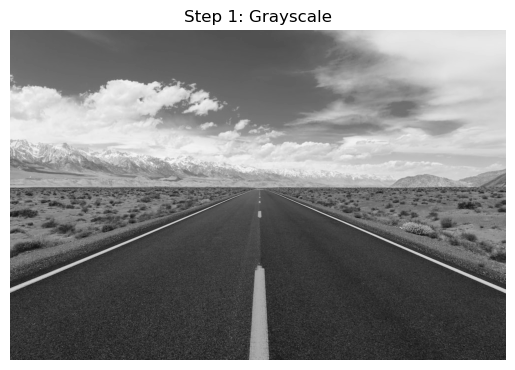

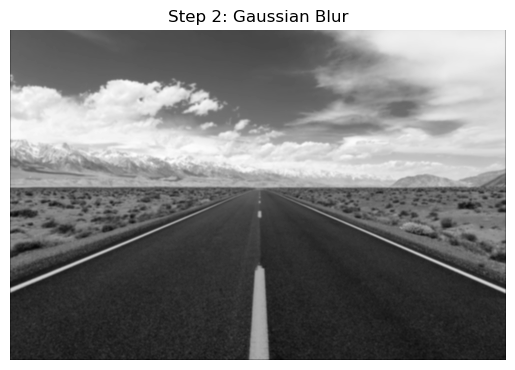

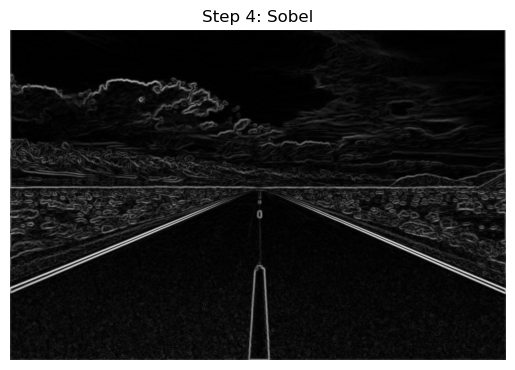

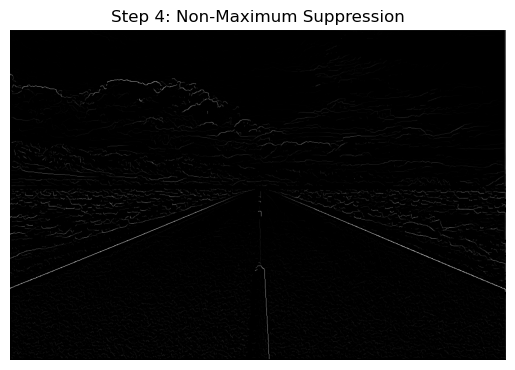

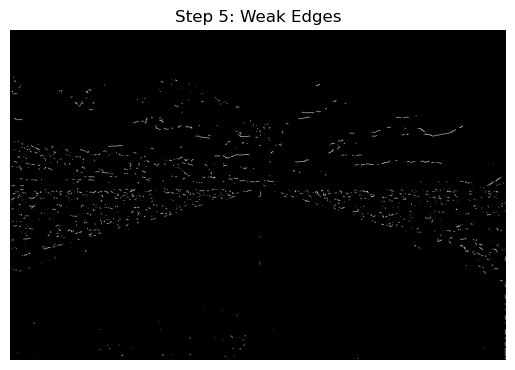

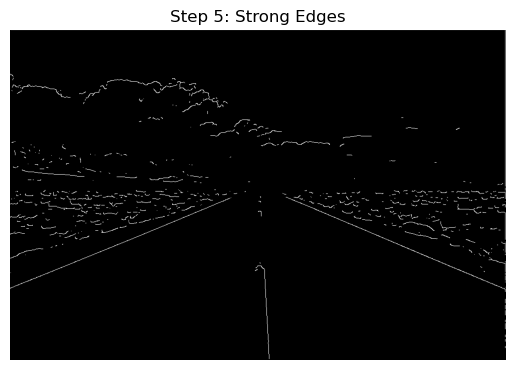

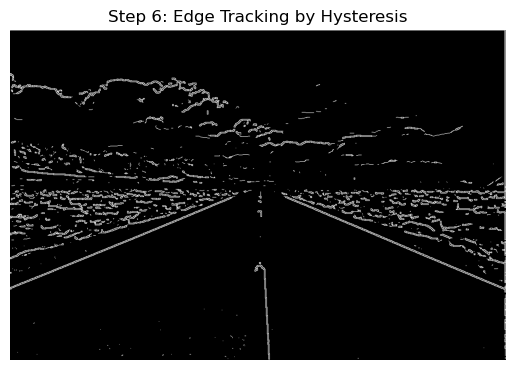

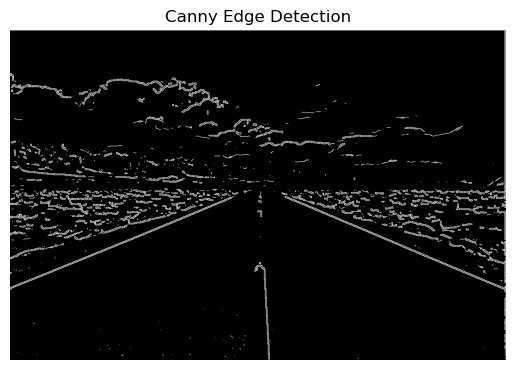

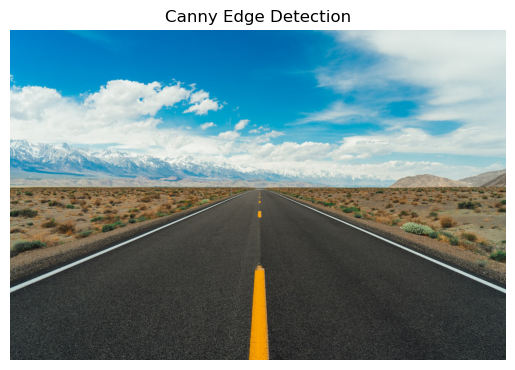

In [422]:
input_image = plt.imread("input2.jpeg")

# Adjust the threshold values here (e.g., low_threshold = 0.1, high_threshold = 0.3)
low_threshold = 0.2
high_threshold = 0.3


# Perform Canny edge detection
edges = canny_edge_detection(input_image, low_threshold, high_threshold)

# Show the edge detection result
plt.imshow(edges, cmap='gray')
plt.title("Canny Edge Detection")
plt.axis('off')
plt.show()

plt.imshow(input_image, cmap='gray')
plt.title("Canny Edge Detection")
plt.axis('off')
plt.show()

In [423]:
def hough_lines(image, edges):
    rho_resolution = 1  # Resolution of the distance parameter (rho)
    theta_resolution = np.pi / 180  # Resolution of the angle parameter (theta)
    threshold = 120  # Minimum number of votes to consider a line
    min_line_length = 100  # Minimum length of the line to be considered
    max_line_gap = 5  # Maximum allowed gap between line segments to be considered part of the same line

    lines = cv2.HoughLinesP(edges, rho_resolution, theta_resolution, threshold, minLineLength=min_line_length, 
            maxLineGap=max_line_gap)

    # Draw the detected lines on the original image
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(image, (x1, y1), (x2, y2), (255, 255, 255), 2)

    return image


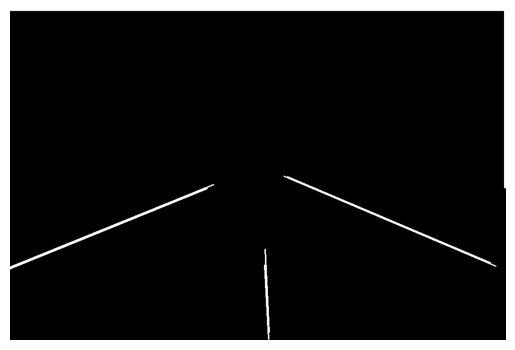

In [410]:
black_image = np.zeros_like(input_image)
edges_uint8 = np.uint8(edges * 255)

# Apply Hough Line Transform and draw lines on the original image
image_with_lines = hough_lines(black_image, edges_uint8)

# Show the result
plt.imshow(image_with_lines)
plt.axis('off')
plt.show()